In [11]:
using DataFrames
using Chemfiles
using MIToS.PDB
using Gadfly
using Cairo
set_default_plot_size(40cm, 14cm)

home2 = "/home/german/labo/18/egfr/2cavidad"
home_rtdos = "/home/german/labo/18/egfr/rtdos_log"
aa = 277

277

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function WeightedHist(in_vec, in_bins, in_weight, density = false)
    # Safety check    
    if length(in_vec) != length(in_weight)
        println("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    for i=1:length(in_bins)-1
        if i == 1
            # Include those that fall before the beggining of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
            out_counts[i] = sum(in_weight[temp_bool])
        elseif i == length(in_bins)-1
            # Include those that fall after the end of the bins
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
            out_counts[i] = sum(in_weight[temp_bool])
        else
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

WeightedHist (generic function with 2 methods)

In [4]:
function displaceAA(mod_pdb, in_vector, multiplier)
    # Preparo variables
    pdb = copy(mod_pdb)
    struct_xyz = coordinatesmatrix(pdb)
    new_struct_xyz = copy(struct_xyz)
        aa = length(pdb)
        # Determino el nro de atomos de c/ aminoácido
        natom = Array{Int64}(aa)
        [ natom[i] = length(pdb[i]) for i = 1:aa ]
        # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
        vector = Array{Float64}
        const tmp_size = size(in_vector)
        const natoms = sum(natom)

        if tmp_size == (aa*3, )
                vector = transpose(reshape(in_vector, 3, aa))
        elseif tmp_size == (aa, 3)
                vector = in_vector
        else
                error("Input vector with wrong dimensions: ", tmp_size, "  ", (aa*3, 1))
        end
        sum_mat = Array{Float64}(sum(natom),3)
        cursor = 0
        for i = 1:aa
                rango = Array{Int64}(natom[i])
        if i == 1
                        sum_mat[1:natom[i], :] = repmat(transpose(vector[i, :]),
                                natom[i], 1)
                        cursor = natom[i]
                        continue
                end
                rango = collect(cursor+1:cursor + natom[i])
                sum_mat[rango, :] = repmat(transpose(vector[i, :]), natom[i], 1)
                cursor += natom[i]
        end

   # Listo, ahora puedo mover el pdb
   new_struct_xyz  = struct_xyz + sum_mat .* multiplier
   pdb = change_coordinates(pdb, new_struct_xyz);
   return pdb
end

displaceAA (generic function with 1 method)

# Cavidad

In [5]:
# Leo nombres de structuras
tmp = readdlm(joinpath(home2, "pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
structs = length(pdbs_list)
n_reps = 500

# Leo activas e inactivas
tmp = readdlm(joinpath(home2, "am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(joinpath(home2, "im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

cfg_filename = joinpath(home2, "egfr.cfg")

"/home/german/labo/18/egfr/1cavidad/egfr.cfg"

### IM

In [58]:
# IM
vol_im = Array{Float64, 2}(n_reps, length(im_list))

for i = 1:length(im_list)
    each = im_list[i]
    
    # Get vol from the orginal pdb
    in_pdb_filename = joinpath(home2, each, string(each, ".pdb"))
    out_filename = joinpath(home2, each, string("vol"))
    run(pipeline(`ANA $in_pdb_filename -c $cfg_filename`, stdout = out_filename))
    vol_orig = readdlm(out_filename)[end]
    
    tmp = Array{Float64, 1}(n_reps)
    
    for j = 1:n_reps
        in_pdb_filename = joinpath(home2, each, string(j, "_", each, ".pdb"))
        out_filename = joinpath(home2, each, string(j, "vol"))
        run(pipeline(`ANA $in_pdb_filename -c $cfg_filename`, stdout = out_filename))
        vol = readdlm(out_filename)[end]
        vol_im[j, i] = vol - vol_orig
    end
    println(each)
end

2GS7_A
2RGP_A
3BEL_A
3GOP_A
3GT8_A
3IKA_B
3W2R_A
3W2S_A
3W32_A
3W33_A
4I1Z_A
4I22_A
4I24_A
4ZJV_A
5CNN_A


### AM

In [59]:
# AM
vol_am = Array{Float64, 2}(n_reps, length(am_list))

for i = 1:length(am_list)
    each = am_list[i]
    
    # Get vol from the orginal pdb
    in_pdb_filename = joinpath(home2, each, string(each, ".pdb"))
    out_filename = joinpath(home2, each, string("vol"))
    run(pipeline(`ANA $in_pdb_filename -c $cfg_filename`, stdout = out_filename))
    vol_orig = readdlm(out_filename)[end]
    
    tmp = Array{Float64, 1}(n_reps)
    
    for j = 1:n_reps
        in_pdb_filename = joinpath(home2, each, string(j, "_", each, ".pdb"))
        out_filename = joinpath(home2, each, string(j, "vol"))
        run(pipeline(`ANA $in_pdb_filename -c $cfg_filename`, stdout = out_filename))
        vol = readdlm(out_filename)[end]
        vol_am[j, i] = vol - vol_orig
    end
    println(each)
end

1M14_A
1M17_A
2EB2_A
2GS2_A
2GS6_A
2ITN_A
2ITP_A
2ITU_A
2ITX_A
2ITZ_A
3IKA_A
3UG1_A
3VJN_A
4G5J_A
4I23_A
4LI5_A
4LQM_A
4R3P_A
4R5S_A
4RJ4_A
4ZAU_A
5C8K_A
5CAO_A
5CAP_A
5CAV_A
5CZH_A


## Grafico

In [78]:
arr_vol_im = abs.(reshape(vol_im, length(vol_im)))
arr_vol_am = abs.(reshape(vol_am, length(vol_am)))

hbins = collect(minimum(arr_vol_im):10.0:maximum(arr_vol_im))
hweights_im = repeat([1.0], inner = [length(arr_vol_im)])
hweights_am = repeat([1.0], inner = [length(arr_vol_am)])

counts_im, bins = WeightedHist(arr_vol_im, hbins, hweights_im, true)
counts_am, bins = WeightedHist(arr_vol_am, hbins, hweights_am, true)

df_arr_vol = DataFrame(Probability = [counts_am ; counts_im],
    ΔVol = [ bins ; bins ],
    Conformer = repeat(["AM" ; "IM"], inner = [ length(bins)]));

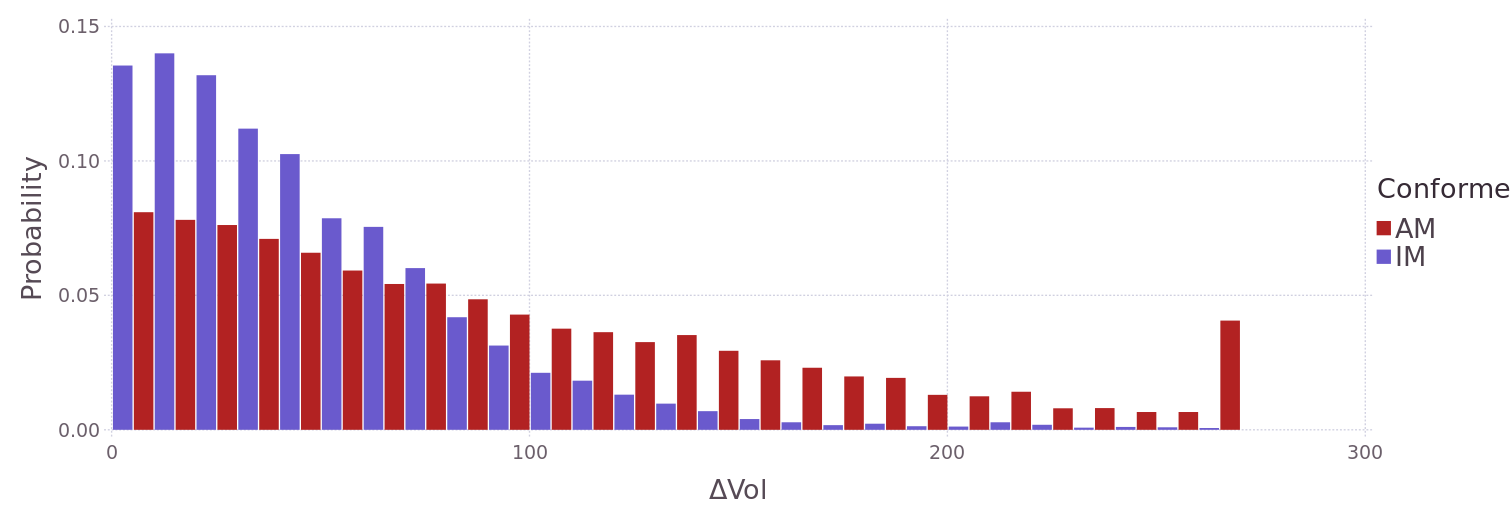

In [79]:
pdf_arr_vol = plot(df_arr_vol, x="ΔVol", y="Probability", color = "Conformer", 
    Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    #Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    #Coord.cartesian(xmin = 0, xmax = 15),
    Scale.color_discrete_manual("Firebrick","SlateBlue"),

    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

## Guardo resultados

In [98]:
writedlm(joinpath(home_rtdos, "arr_vol_im"), arr_vol_im)
writedlm(joinpath(home_rtdos, "arr_vol_am"), arr_vol_am)